In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pickle 

from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import layers
from sklearn.preprocessing import MinMaxScaler


import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('keras').setLevel(logging.ERROR)


2023-07-15 20:20:25.368866: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-15 20:20:25.425159: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-15 20:20:25.425855: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 20:20:26.538057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
df = pd.read_csv('historic_readings_no_missing_data.csv'
        ).drop(columns=['Unnamed: 0']
        ).sort_values(by='timestamp')

In [19]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity'])


df_temp.set_index('timestamp',inplace=True)
df_temp.dropna(inplace=True)
df_temp

,temperature
timestamp,
2023-05-01 00:10:00,20.67
2023-05-01 00:20:00,20.71
2023-05-01 00:30:00,20.70
2023-05-01 00:40:00,20.63
2023-05-01 00:50:00,20.64
...,...
2023-07-14 17:00:00,23.47
2023-07-14 17:10:00,23.57
2023-07-14 17:20:00,23.47


### How to do train/test/validation splits?

From Chollet - Deep Learning with Python, version 2, p.284

*In all our experiments, we’ll use the first 50% of the data for training, the follow-
ing 25% for validation, and the last 25% for testing. When working with timeseries
data, it’s important to use validation and test data that is more recent than the train-
ing data, because you’re trying to predict the future given the past, not the reverse,
and your validation/test splits should reflect that. Some problems happen to be con-
siderably simpler if you reverse the time axis!*

But in this context, we're going to give the model the previous hour of data and get it to predict in 2 hours, so there'll be some information shared. Let's assume there is periodicity, but that we don't have a complete period now. 

So could do:

- Sequentially do 60%, 20%, 20% as train/val/test - but then this means val will be much higher due to hot weather
- Sample blocks https://royalsocietypublishing.org/doi/10.1098/rsta.2020.0097
- k-fold cross validation for time series forecasting - seems better, scikit-learn implementation here https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split

For now we have clear periodicity, and the models will be forecasting ahead 2 hours, so data leakage will probably not be as big an issue. 

For now will do sequential, and then val performance will not be as good

To revisit later. 



In [20]:
# Split the data, 60% in training and 20% in validation, 20% in test, and not randomly selected since this is a time series

scaler = MinMaxScaler()

last_train_index = int(np.round(df_temp['temperature'].shape[0]*0.6))
last_val_index = int(np.round(df_temp['temperature'].shape[0]*0.8))

train_data = df_temp.iloc[:last_train_index,]
validation_data = df_temp.iloc[last_train_index:last_val_index]
test_data = df_temp.iloc[last_val_index:]

# Fit to the train set, then transform the train set and the test set
# TODO: Check, should not fit on test set?

scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_validation = scaler.transform(validation_data)
scaled_test = scaler.transform(test_data)




In [43]:
scaler.get_params()

{'clip': False, 'copy': True, 'feature_range': (0, 1)}

In [28]:
delay = 24
sequence_length = 12

train = keras.preprocessing.timeseries_dataset_from_array(scaled_train[:-delay], scaled_train[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

validation = keras.preprocessing.timeseries_dataset_from_array(scaled_validation[:-delay], scaled_validation[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

test = keras.preprocessing.timeseries_dataset_from_array(scaled_test[:-delay], scaled_test[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

In [38]:
for inputs, targets in test:
    print(targets)

tf.Tensor([[0.40872211]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.72210953]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.73630832]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.53752535]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.6703854]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.57707911]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.44726166]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.72718053]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.56693712]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.5841785]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.54361055]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.4979716]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.53042596]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.73326572]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.43306288]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.60547667]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.72920892]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.64097363]], shape=(1, 1), dtype=float64)
tf.Tensor([[0

In [29]:
# Baseline

def evalute_naive_method(dataset):

    total_abs_err = 0
    samples_seen = 0

    for samples, targets in dataset:
        preds = samples[:, -1]
        total_abs_err += np.sum(np.abs(preds-targets))
        #print(preds, targets, total_abs_err)
        samples_seen += samples.shape[0]
    
    return total_abs_err / samples_seen

persistence_mae = evalute_naive_method(test) 

print(f'Baseline: persistence forecast for 2 hours - MAE: {persistence_mae*100:.2f}%')

2023-07-15 21:18:51.256748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [2119]
	 [[{{node Placeholder/_28}}]]
2023-07-15 21:18:51.257692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


Baseline: persistence forecast for 2 hours - MAE: 3.38%


## First LSTM model

In [31]:
inputs = keras.Input(shape=(12, 1))

x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train,
                    epochs=5,
                    validation_data=validation)


loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)



Epoch 1/5


2023-07-15 21:19:06.657030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-15 21:19:06.658926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-15 21:19:06.660536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6424/6428 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0566

2023-07-15 21:19:47.631553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [2118,1]
	 [[{{node Placeholder/_20}}]]
2023-07-15 21:19:47.632173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2130,1]
	 [[{{node Placeholder/_0}}]]
2023-07-15 21:19:47.846891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

6428/6428 [==============================] - 45s 7ms/step - loss: 0.0057 - mae: 0.0566 - val_loss: 0.0125 - val_mae: 0.0897
Epoch 2/5
6428/6428 [==============================] - 41s 6ms/step - loss: 0.0047 - mae: 0.0521 - val_loss: 0.0126 - val_mae: 0.0897
Epoch 3/5
6428/6428 [==============================] - 41s 6ms/step - loss: 0.0042 - mae: 0.0479 - val_loss: 0.0092 - val_mae: 0.0777
Epoch 4/5
6428/6428 [==============================] - 41s 6ms/step - loss: 0.0041 - mae: 0.0471 - val_loss: 0.0117 - val_mae: 0.0874
Epoch 5/5
6428/6428 [==============================] - 41s 6ms/step - loss: 0.0040 - mae: 0.0464 - val_loss: 0.0081 - val_mae: 0.0732


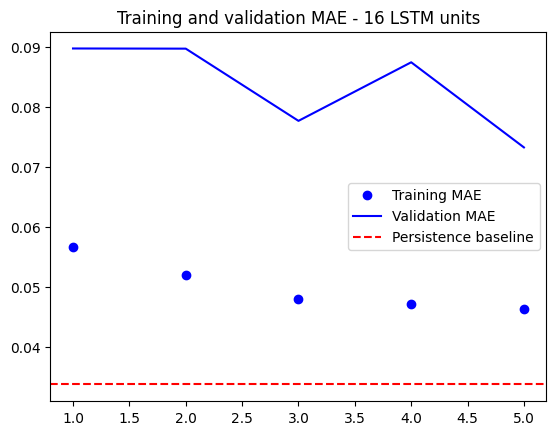

In [32]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.axhline(y=persistence_mae, color='r', linestyle='--', label='Persistence baseline')
plt.title(f'Training and validation MAE - 16 LSTM units')
plt.legend()
plt.show()

In [33]:
inputs = keras.Input(shape=(12, 1))

x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train,
                    epochs=10,
                    validation_data=validation)


loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)



Epoch 1/10
6428/6428 [==============================] - 54s 8ms/step - loss: 0.0054 - mae: 0.0558 - val_loss: 0.0097 - val_mae: 0.0808
Epoch 2/10
6428/6428 [==============================] - 48s 8ms/step - loss: 0.0049 - mae: 0.0531 - val_loss: 0.0101 - val_mae: 0.0818
Epoch 3/10
6428/6428 [==============================] - 49s 8ms/step - loss: 0.0047 - mae: 0.0521 - val_loss: 0.0093 - val_mae: 0.0790
Epoch 4/10
6428/6428 [==============================] - 50s 8ms/step - loss: 0.0047 - mae: 0.0518 - val_loss: 0.0103 - val_mae: 0.0826
Epoch 5/10
6428/6428 [==============================] - 50s 8ms/step - loss: 0.0045 - mae: 0.0505 - val_loss: 0.0118 - val_mae: 0.0878
Epoch 6/10
6428/6428 [==============================] - 49s 8ms/step - loss: 0.0044 - mae: 0.0497 - val_loss: 0.0115 - val_mae: 0.0865
Epoch 7/10
6428/6428 [==============================] - 51s 8ms/step - loss: 0.0044 - mae: 0.0495 - val_loss: 0.0108 - val_mae: 0.0841
Epoch 8/10
6428/6428 [==============================] -

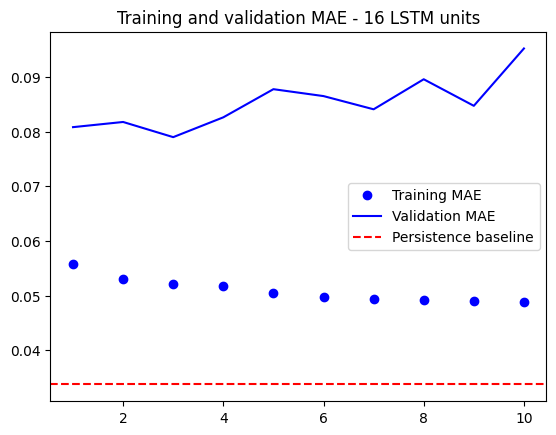

In [34]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.axhline(y=persistence_mae, color='r', linestyle='--', label='Persistence baseline')
plt.title(f'Training and validation MAE - 16 LSTM units')
plt.legend()
plt.show()

In [42]:
for input, target in test:
    print(input)

tf.Tensor(
[[[0.49492901]
  [0.48478702]
  [0.48377282]
  [0.48884381]
  [0.49290061]
  [0.47565923]
  [0.48580122]
  [0.49290061]
  [0.48782961]
  [0.49492901]
  [0.4979716 ]
  [0.5010142 ]]], shape=(1, 12, 1), dtype=float64)
tf.Tensor(
[[[0.46754564]
  [0.46957404]
  [0.45943205]
  [0.46348884]
  [0.46146045]
  [0.45638945]
  [0.45436105]
  [0.45740365]
  [0.45638945]
  [0.44320487]
  [0.45233266]
  [0.45233266]]], shape=(1, 12, 1), dtype=float64)
tf.Tensor(
[[[0.50608519]
  [0.4959432 ]
  [0.4979716 ]
  [0.5030426 ]
  [0.49492901]
  [0.48478702]
  [0.48377282]
  [0.48884381]
  [0.49290061]
  [0.47565923]
  [0.48580122]
  [0.49290061]]], shape=(1, 12, 1), dtype=float64)
tf.Tensor(
[[[0.46653144]
  [0.47363083]
  [0.46754564]
  [0.46146045]
  [0.47464503]
  [0.46146045]
  [0.47160243]
  [0.48073022]
  [0.47565923]
  [0.47870183]
  [0.48884381]
  [0.47464503]]], shape=(1, 12, 1), dtype=float64)
tf.Tensor(
[[[0.72920892]
  [0.72312373]
  [0.72210953]
  [0.72413793]
  [0.73326572]
  [0.7

In [39]:
model.predict()

TypeError: '_BatchDataset' object is not subscriptable

In [37]:
# Ok let's just deploy anyway, can fix this awful model later

model.save('basic_model.keras')

In [11]:
def try_lstm_n_nodes(n):

    inputs = keras.Input(shape=(36, 1))

    x = layers.LSTM(n)(inputs)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    history = model.fit(train,
                        epochs=3,
                        validation_data=validation)

    
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)

    print(f'\n========= \
            \nCompleted run for n={n} nodes. \
            \n========= \
            \nFinal val_loss: {val_loss[-1]}' )
    return {'loss': loss, 'val_loss' : val_loss, 'epochs' : epochs}

results = {}

for i in [1,2,4,8,16,32]:
    print(i)
    results[f'{i}'] = try_lstm_n_nodes(i)

with open('lstm_node_experiments.pkl', 'wb') as f:
    pickle.dump(results, f)


1
Epoch 1/10
2207/2207 [==============================] - 10s 4ms/step - loss: 0.0075 - mae: 0.0644 - val_loss: 0.0077 - val_mae: 0.0595
Epoch 2/10
2207/2207 [==============================] - 8s 4ms/step - loss: 0.0030 - mae: 0.0434 - val_loss: 0.0073 - val_mae: 0.0589
Epoch 3/10
2207/2207 [==============================] - 9s 4ms/step - loss: 0.0028 - mae: 0.0414 - val_loss: 0.0076 - val_mae: 0.0589
Epoch 4/10
2207/2207 [==============================] - 9s 4ms/step - loss: 0.0027 - mae: 0.0410 - val_loss: 0.0074 - val_mae: 0.0583
Epoch 5/10
2207/2207 [==============================] - 9s 4ms/step - loss: 0.0026 - mae: 0.0403 - val_loss: 0.0072 - val_mae: 0.0576
Epoch 6/10
2207/2207 [==============================] - 9s 4ms/step - loss: 0.0025 - mae: 0.0399 - val_loss: 0.0069 - val_mae: 0.0571
Epoch 7/10
2207/2207 [==============================] - 9s 4ms/step - loss: 0.0025 - mae: 0.0397 - val_loss: 0.0072 - val_mae: 0.0570
Epoch 8/10
2207/2207 [==============================] - 9s 

## Loading results and displaying training runs

In [12]:
with open('lstm_node_experiments.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

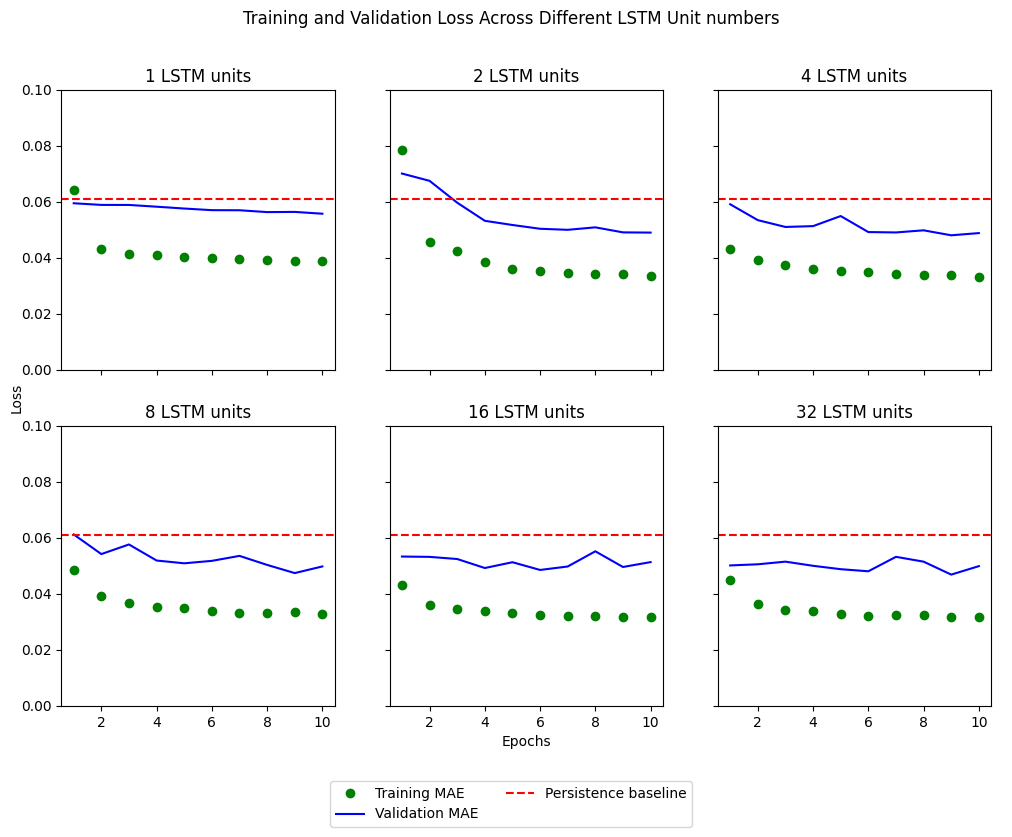

In [13]:
persistence_baseline = persistence_mae


# Create the figure and axes
fig, axes = plt.subplots(figsize=(12,8), nrows=2, ncols=3, sharex=True, sharey=True)

# Loop over the subplots and plot the data
for i, ax in enumerate(axes.flatten()):

    key = list(loaded_dict.keys())[i]

    epochs = loaded_dict[key]['epochs']
    loss = loaded_dict[key]['loss']
    val_loss = loaded_dict[key]['val_loss']

    ax.plot(epochs, loss, "go", label="Training MAE")
    ax.plot(epochs, val_loss, "b", label="Validation MAE")
    ax.axhline(y=persistence_baseline, color='r', linestyle='--', label='Persistence baseline')
    ax.set_ylim(0,0.1)
    ax.set_title(f"{key} LSTM units")
    

# Add a common x-axis label and a common y-axis label
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
plt.xlabel("Epochs")
plt.ylabel("Loss")


# Add the legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

fig.suptitle("Training and Validation Loss Across Different LSTM Unit numbers")

# Display the figure
plt.show()
